# Image Enhancement
In this notebook we use i.a. Regularised Diffusion-Shock (RDS) filtering on $\mathbb{M}_2$ to denoise images corrupted by correlated white noise, as in Section 6.1 of ["Diffusion-Shock Filtering on the Space of Positions and Orientations"](https://arxiv.org/abs/2502.17146).

In [1]:
import taichi as ti
ti.init(arch=ti.gpu, debug=False, device_memory_GB=3.5)
import numpy as np
from PIL import Image
from dsfilter import (
    DS_enhancing_LI,
    DS_enhancing_gauge,
    DS_enhancing_R2,
    TV_enhancing_LI,
    TV_enhancing_gauge
)
from dsfilter.M2.utils import (
    coordinate_array_to_real,
    vectorfield_static_to_LI_np
)
from dsfilter.orientationscore import (
    cakewavelet_stack,
    wavelet_transform
)
from dsfilter.M2.gauge.frame import compute_gauge_frame_and_orientation_confidence
from dsfilter.visualisations import (
    align_to_real_axis_scalar_field,
    align_to_standard_array_axis_scalar_field,
    plot_image_array
)
from bm3d import bm3d
from skimage.restoration import denoise_nl_means
from tqdm import tqdm
import matplotlib.pyplot as plt

[Taichi] version 1.6.0, llvm 15.0.1, commit f1c6fbbd, win, python 3.10.15
[Taichi] Starting on arch=cuda


## Test Cases
In the paper, we denoise two images corrupted with correlated noise $K_\rho * n_\sigma$, where $K_\rho$ is a Gaussian with standard deviation $\rho$ and $n_\sigma$ is white noise with intensity $\sigma$, namely
* [Retina](.\\data\\retina.tif) (Fig. 4), corrupted with $\sigma = 127.5$, $\rho = 2$, and
* [Spiral](.\\data\\spiral.tif) (Fig. 5), corrupted with $\sigma = 255$, $\rho = 2$.

One can of course also generate images with other noise profiles.

In [2]:
# "retina" "spiral"
test_case = "retina"
σ_noise = 255. * 0.5
ρ_noise = 2.
storage_name = f"{test_case}_{σ_noise:.0f}_{ρ_noise:.0f}"

### Parameters & Setup
These parameters we keep the same for all experiments:

In [3]:
dim_K = 16 # Number of orientations.
ξ = 0.1 # Stiffness parameter for gauge frames.

# RDS Parameters
## R2
λ_R2 = 10.
ε_R2 = λ_R2 * 0.15
## M2
λ_M2 = 0.5
ε_M2 = 165.
ζ_D = 1. # Spatial anisotropy in the diffusion.
ζ_S = 0.5 # Spatial anisotropy in the shock.
### (Dual) metric tensor fields.
G_D_inv_gauge = np.array((1., ζ_D**2, 1.))
G_S_inv_gauge = np.array((1., ζ_S**2, 1.))
G_D_inv = np.array((ξ**-2, (ζ_D / ξ)**2, 1.))
G_S_inv = np.array((ξ**-2, (ζ_S / ξ)**2, 1.))

# TR-TV Parameters
λ_TV = 50. / 255.
### (Dual) metric tensor fields.
ζ = 1.
G_TV_inv_gauge = np.array((1., ζ**2, 1.))
G_TV_inv = np.array((ξ**-2, (ζ/ξ)**2, 1.))

We need different regularisation scales and stopping times depending on the underlying image.

In [4]:
match test_case:
    case "retina":
        # RDS Parameters
        σ = 0.2
        ρ = 0.2
        ν = 0.2
        ## R2
        t_DS_R2 = 30.
        ## M2
        t_DS_M2 = 1.
        # TR-TV Parameters
        t_TV = 0.25
        # NLM Parameters
        σ_max_nlm = 50.
        σ_step_nlm = 1.
        # BM3D Parameters
        σ_max_bm3d = 200
        σ_step_bm3d = 5.

        # Plotting.
        im_width = 6
        im_height = 5
    case "spiral":
        # RDS Parameters
        σ = 0.2
        ρ = 1.9
        ν = 2.1
        ## R2
        t_DS_R2 = 15.
        ## M2
        t_DS_M2 = 2.
        # TR-TV Parameters
        t_TV = 0.25
        # NLM Parameters
        σ_max_nlm = 100.
        σ_step_nlm = 2.
        # BM3D Parameters
        σ_max_bm3d = 250.
        σ_step_bm3d = 10.

        # Plotting.
        im_width = 9
        im_height = 5

σs_nlm = np.arange(0., σ_max_nlm, σ_step_nlm)
σs_bm3d = np.arange(0., σ_max_bm3d, σ_step_bm3d)

# Load image
ground_truth = np.array(Image.open(f"data/{test_case}.tif").convert("L")).astype(np.float64)
np.random.seed(123456)
noise = σ_noise * np.random.randn(*ground_truth.shape)
if ρ_noise > 0:
    import scipy as sp
    noise = sp.ndimage.gaussian_filter(noise, ρ_noise)
noisy = np.clip(ground_truth + noise, 0., 255.)
ground_truth = align_to_real_axis_scalar_field(ground_truth)
noisy = align_to_real_axis_scalar_field(noisy)

In [5]:
clip = (0., 255.)

dim_I, dim_J = ground_truth.shape
Is, Js, Ks = np.indices((dim_I, dim_J, dim_K))
x_min, x_max = 0., dim_I - 1.
y_min, y_max = 0., dim_J - 1.
θ_min, θ_max = 0., 2 * np.pi
dxy = (x_max - x_min) / (dim_I - 1)
dθ = (θ_max - θ_min) / dim_K
xs, ys, θs = coordinate_array_to_real(Is, Js, Ks, x_min, y_min, θ_min, dxy, dθ)

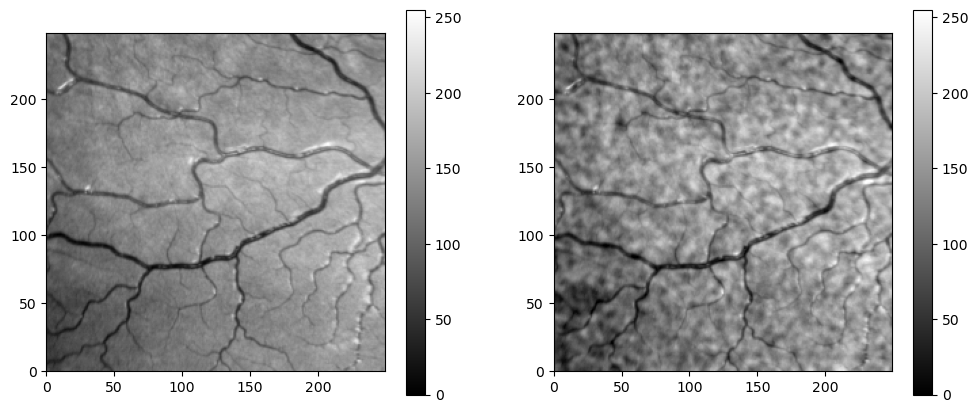

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(2 * im_width, im_height))
_, _, cbar = plot_image_array(ground_truth, 0., dim_I - 1., 0., dim_J - 1., fig=fig, ax=ax[0])
fig.colorbar(cbar, ax=ax[0])
_, _, cbar = plot_image_array(noisy, 0., dim_I - 1., 0., dim_J - 1., fig=fig, ax=ax[1])
fig.colorbar(cbar, ax=ax[1]);

### Quality Metrics

In [7]:
def PSNR(denoised, ground_truth, max=255.):
    return 10 * np.log10(max**2 / np.mean((denoised - ground_truth)**2))

def L2(denoised, ground_truth):
    return np.sqrt(((denoised - ground_truth)**2).mean())

def L1(denoised, ground_truth):
    return np.abs(denoised - ground_truth).mean()

## Orientation Score

In [8]:
cws = cakewavelet_stack(min(dim_I, dim_J), dim_K, inflection_point=0.95, Gaussian_σ=dim_I/12).real
U = wavelet_transform(noisy, cws).real
U = np.transpose(U, axes=(1, 2, 0)) # x, y, θ

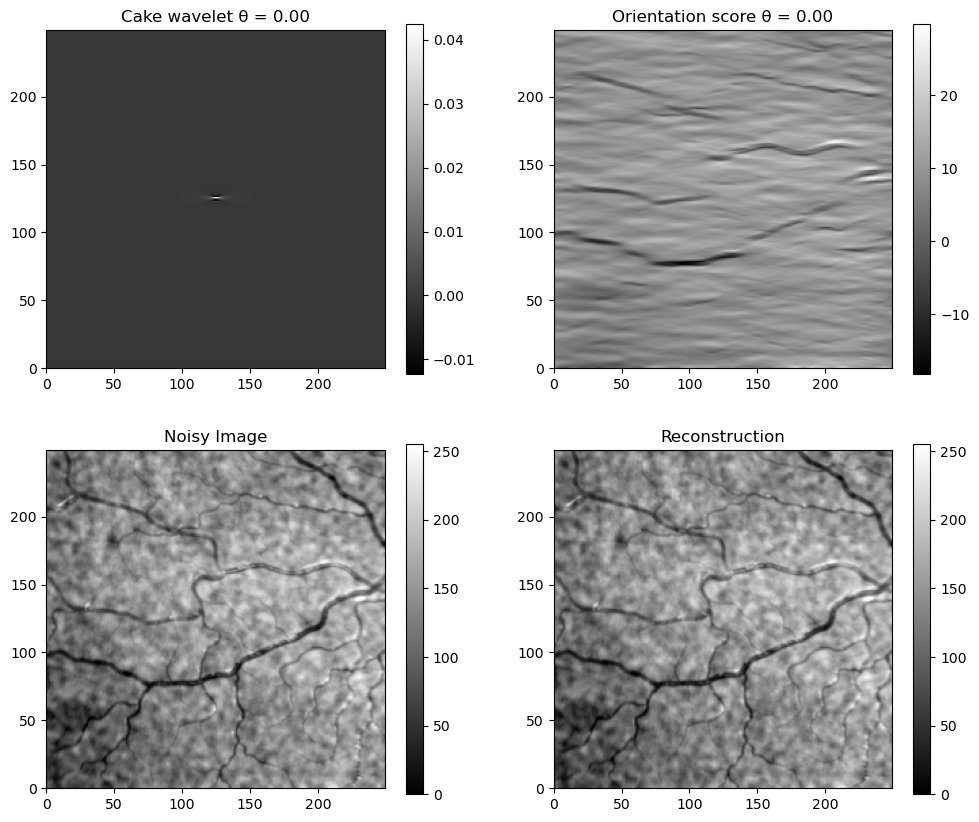

In [9]:
K = 0
fig, ax = plt.subplots(2, 2, figsize=(2 * im_width, 2 * im_height))
_, _, cbar = plot_image_array(cws[K], x_min, x_max, y_min, y_max, fig=fig, ax=ax[0, 0])
ax[0, 0].set_title(f"Cake wavelet θ = {K * dθ:.2f}") 
fig.colorbar(cbar, ax=ax[0, 0])
_, _, cbar = plot_image_array(U[..., K], x_min, x_max, y_min, y_max, fig=fig, ax=ax[0, 1])
ax[0, 1].set_title(f"Orientation score θ = {K * dθ:.2f}") 
fig.colorbar(cbar, ax=ax[0, 1])
_, _, cbar = plot_image_array(noisy, x_min, x_max, y_min, y_max, fig=fig, ax=ax[1, 0], clip=clip)
ax[1, 0].set_title("Noisy Image")
fig.colorbar(cbar, ax=ax[1, 0])
_, _, cbar = plot_image_array(U.sum(-1), x_min, x_max, y_min, y_max, fig=fig, ax=ax[1, 1], clip=clip)
ax[1, 1].set_title("Reconstruction")
fig.colorbar(cbar, ax=ax[1, 1]);

### Gauge Frames

In [10]:
B1_LI, B2_LI, B3_LI, _ = compute_gauge_frame_and_orientation_confidence(U, dxy, dθ, θs, ξ, ρ_s=1.5)
B1_static = vectorfield_static_to_LI_np(B1_LI, θs)
B2_static = vectorfield_static_to_LI_np(B2_LI, θs)
B3_static = vectorfield_static_to_LI_np(B3_LI, θs)
gauge_frame_static = (B1_static, B2_static, B3_static)

## Perform Filtering

### RDS

#### Left-Invariant

In [11]:
σ = 0.2 # 0.2
ρ = 0.2 # 0.2
ν = 0.2 # 0.2

λ_M2 = 0.5 # 0.5
ε_M2 = 165. # 165.
ζ_D = 1. # Spatial anisotropy in the diffusion.
ζ_S = 0.5 # Spatial anisotropy in the shock.
### (Dual) metric tensor fields.
G_D_inv_gauge = np.array((1., ζ_D**2, 1.))
G_S_inv_gauge = np.array((1., ζ_S**2, 1.))
G_D_inv = np.array((ξ**-2, (ζ_D / ξ)**2, 1.))
G_S_inv = np.array((ξ**-2, (ζ_S / ξ)**2, 1.))

In [12]:
ξ, t_DS_M2, G_D_inv, G_S_inv, σ, ρ, ν, λ_M2, ε_M2

(0.1,
 1.0,
 array([100., 100.,   1.]),
 array([100.,  25.,   1.]),
 0.2,
 0.2,
 0.2,
 0.5,
 165.0)

In [13]:
_, PSNRs_DS_LI, L2s_DS_LI, L1s_DS_LI = DS_enhancing_LI(U, ground_truth, θs, ξ, t_DS_M2, G_D_inv, G_S_inv, σ, ρ, ν, λ_M2, ε=ε_M2, dxy=dxy)

100%|██████████| 825/825 [00:06<00:00, 125.80it/s]


In [14]:
PSNRs_DS_LI.max()

np.float64(25.25891876220703)

In [15]:
# First solve for long stopping time to find optimum in terms of PSNR.
_, PSNRs_DS_LI, L2s_DS_LI, L1s_DS_LI = DS_enhancing_LI(U, ground_truth, θs, ξ, t_DS_M2, G_D_inv, G_S_inv, σ, ρ, ν, λ_M2, ε=ε_M2, dxy=dxy)
t_opt_DS_LI = t_DS_M2 * max(PSNRs_DS_LI.argmax(), 1) / PSNRs_DS_LI.shape[0]
# Result at optimal stopping time.
U_DS_LI, _, _, _ = DS_enhancing_LI(U, ground_truth, θs, ξ, t_opt_DS_LI, G_D_inv, G_S_inv, σ, ρ, ν, λ_M2, ε=ε_M2, dxy=dxy)

100%|██████████| 357/357 [00:04<00:00, 72.06it/s] 


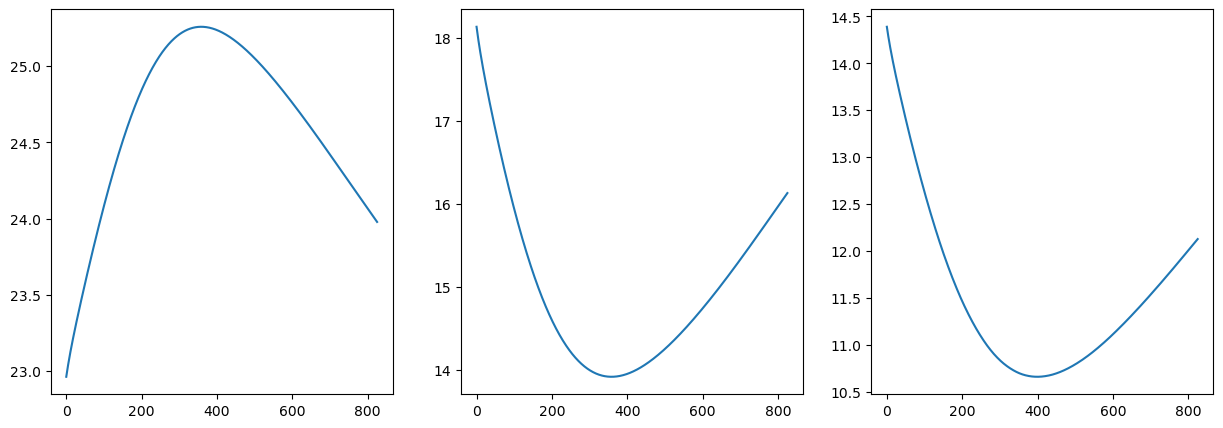

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(PSNRs_DS_LI)
ax[1].plot(L2s_DS_LI)
ax[2].plot(L1s_DS_LI);

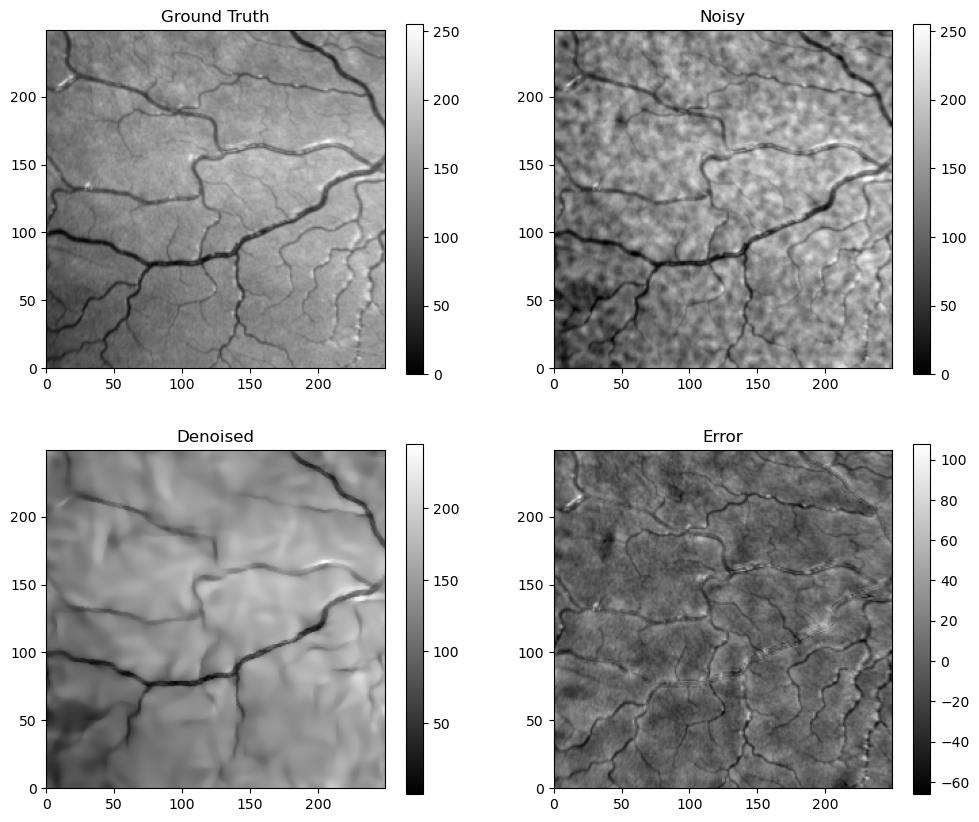

In [17]:
fig, ax = plt.subplots(2, 2, figsize=(2 * im_width, 2 * im_height))
_, _, cbar = plot_image_array(ground_truth, x_min, x_max, y_min, y_max, fig=fig, ax=ax[0, 0])
ax[0, 0].set_title("Ground Truth")
fig.colorbar(cbar, ax=ax[0, 0])
_, _, cbar = plot_image_array(noisy, x_min, x_max, y_min, y_max, fig=fig, ax=ax[0, 1])
ax[0, 1].set_title("Noisy")
fig.colorbar(cbar, ax=ax[0, 1])
_, _, cbar = plot_image_array(U_DS_LI.sum(-1), x_min, x_max, y_min, y_max, clip=clip, fig=fig, ax=ax[1, 0])
ax[1, 0].set_title("Denoised")
fig.colorbar(cbar, ax=ax[1, 0])
_, _, cbar = plot_image_array(ground_truth - np.clip(U_DS_LI.sum(-1), *clip), x_min, x_max, y_min, y_max, fig=fig, ax=ax[1, 1])
fig.colorbar(cbar, ax=ax[1, 1])
ax[1, 1].set_title("Error");

#### Gauge

In [18]:
# First solve for long stopping time to find optimum in terms of PSNR.
_, PSNRs_DS_gauge, L2s_DS_gauge, L1s_DS_gauge = DS_enhancing_gauge(U, ground_truth, θs, ξ, gauge_frame_static, t_DS_M2, G_D_inv_gauge, G_S_inv_gauge, σ, ρ, ν, λ_M2, ε=ε_M2, dxy=dxy)
t_opt_DS_gauge = t_DS_M2 * max(PSNRs_DS_gauge.argmax(), 1) / PSNRs_DS_gauge.shape[0]
# Result at optimal stopping time.
U_DS_gauge, _, _, _ = DS_enhancing_gauge(U, ground_truth, θs, ξ, gauge_frame_static, t_opt_DS_gauge, G_D_inv_gauge, G_S_inv_gauge, σ, ρ, ν, λ_M2, ε=ε_M2, dxy=dxy)

100%|██████████| 270/270 [00:05<00:00, 46.33it/s] 


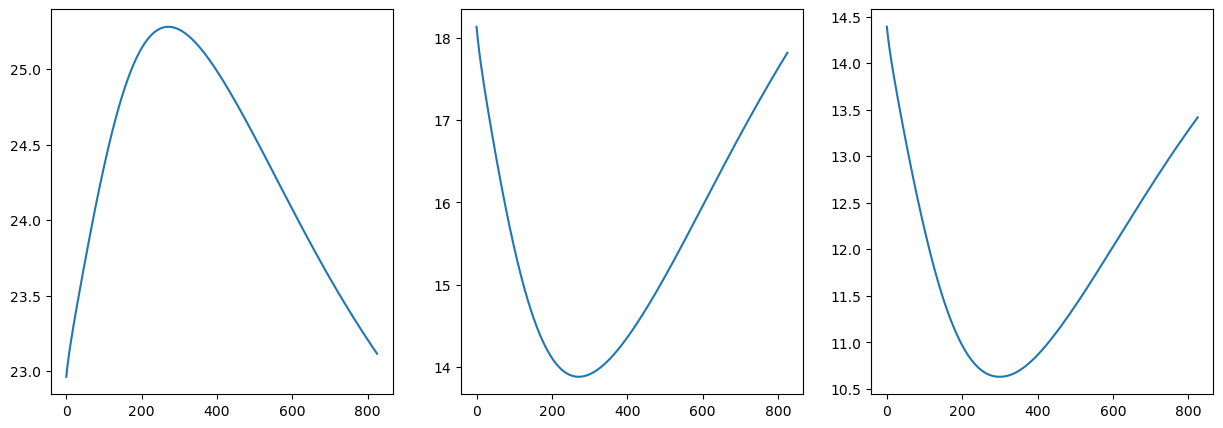

In [19]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(PSNRs_DS_gauge)
ax[1].plot(L2s_DS_gauge)
ax[2].plot(L1s_DS_gauge);

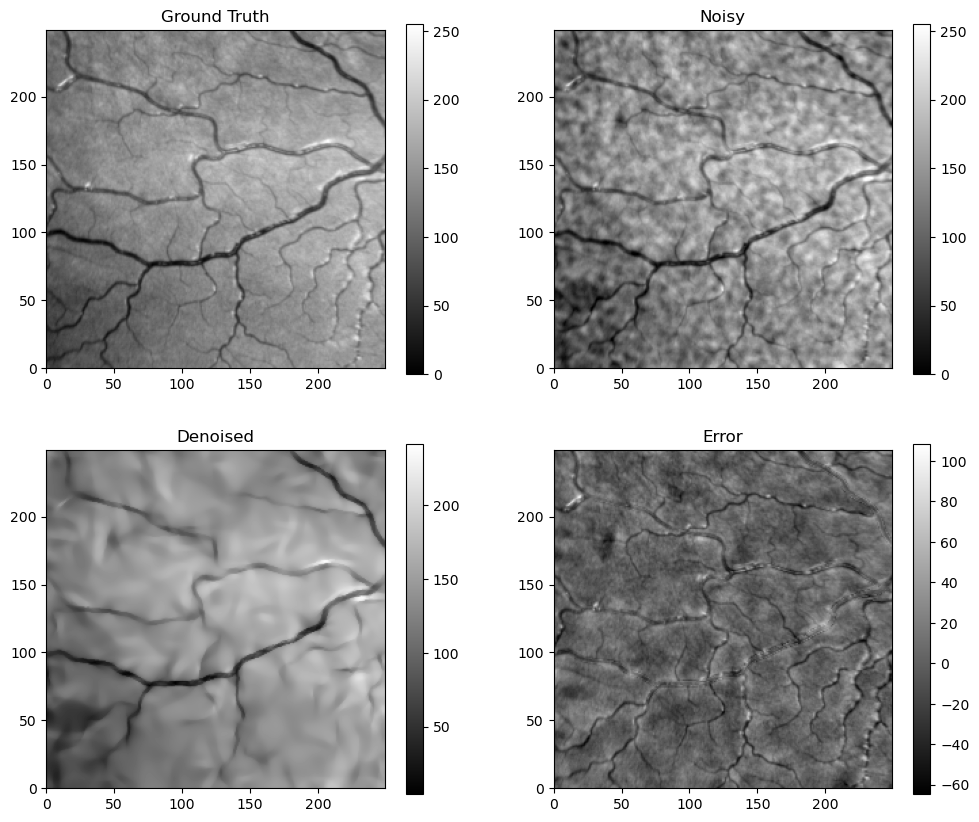

In [20]:
fig, ax = plt.subplots(2, 2, figsize=(2 * im_width, 2 * im_height))
_, _, cbar = plot_image_array(ground_truth, x_min, x_max, y_min, y_max, fig=fig, ax=ax[0, 0])
ax[0, 0].set_title("Ground Truth")
fig.colorbar(cbar, ax=ax[0, 0])
_, _, cbar = plot_image_array(noisy, x_min, x_max, y_min, y_max, fig=fig, ax=ax[0, 1])
ax[0, 1].set_title("Noisy")
fig.colorbar(cbar, ax=ax[0, 1])
_, _, cbar = plot_image_array(U_DS_gauge.sum(-1), x_min, x_max, y_min, y_max, clip=clip, fig=fig, ax=ax[1, 0])
ax[1, 0].set_title("Denoised")
fig.colorbar(cbar, ax=ax[1, 0])
_, _, cbar = plot_image_array(ground_truth - np.clip(U_DS_gauge.sum(-1), *clip), x_min, x_max, y_min, y_max, fig=fig, ax=ax[1, 1])
fig.colorbar(cbar, ax=ax[1, 1])
ax[1, 1].set_title("Error");

#### $\mathbb{R}^2$

In [21]:
# First solve for long stopping time to find optimum in terms of PSNR.
_, PSNRs_DS_R2, L2s_DS_R2, L1s_DS_R2 = DS_enhancing_R2(noisy, ground_truth, t_DS_R2, σ, ρ, ν, λ_R2, ε=ε_R2, dxy=dxy)
t_opt_DS_R2 = t_DS_R2 * max(PSNRs_DS_R2.argmax(), 1) / PSNRs_DS_R2.shape[0]
# Result at optimal stopping time.
u_DS_R2, _, _, _ = DS_enhancing_R2(noisy, ground_truth, t_opt_DS_R2, σ, ρ, ν, λ_R2, ε=ε_R2, dxy=dxy)

100%|██████████| 8/8 [00:01<00:00,  6.38it/s]


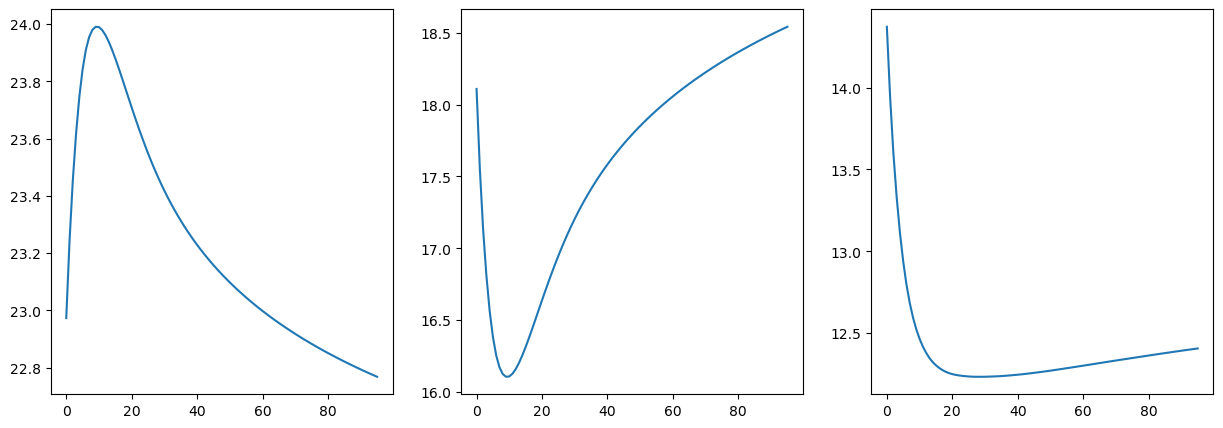

In [22]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(PSNRs_DS_R2)
ax[1].plot(L2s_DS_R2)
ax[2].plot(L1s_DS_R2);

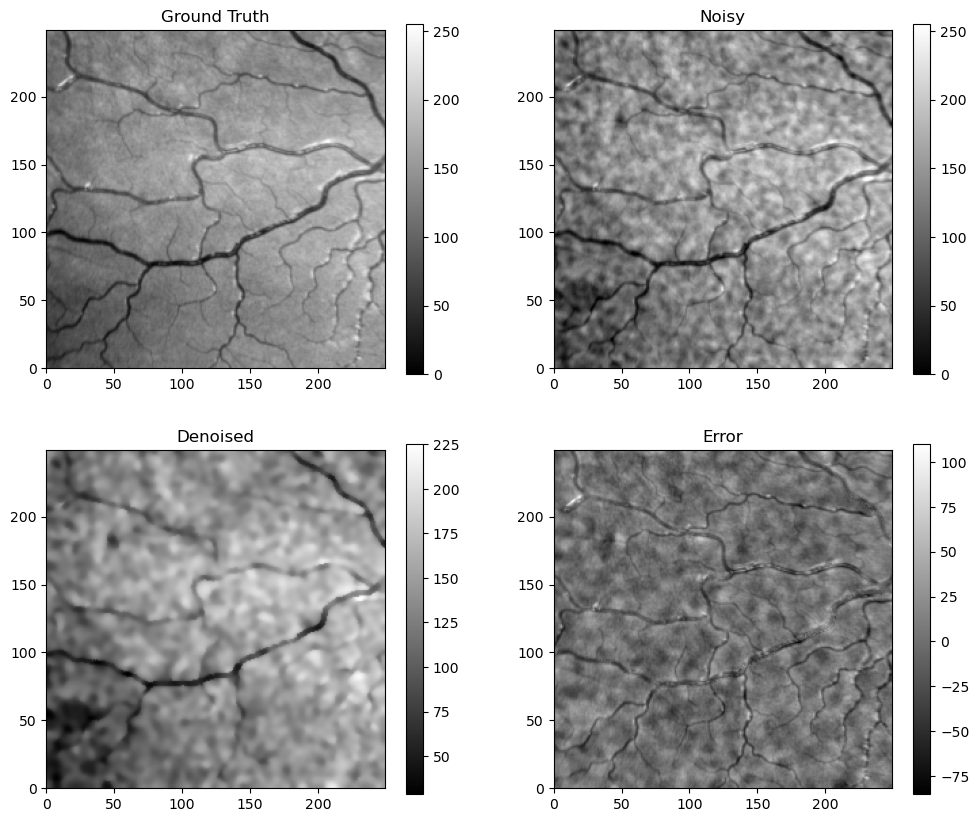

In [23]:
fig, ax = plt.subplots(2, 2, figsize=(2 * im_width, 2 * im_height))
_, _, cbar = plot_image_array(ground_truth, x_min, x_max, y_min, y_max, fig=fig, ax=ax[0, 0])
ax[0, 0].set_title("Ground Truth")
fig.colorbar(cbar, ax=ax[0, 0])
_, _, cbar = plot_image_array(noisy, x_min, x_max, y_min, y_max, fig=fig, ax=ax[0, 1])
ax[0, 1].set_title("Noisy")
fig.colorbar(cbar, ax=ax[0, 1])
_, _, cbar = plot_image_array(u_DS_R2, x_min, x_max, y_min, y_max, clip=clip, fig=fig, ax=ax[1, 0])
ax[1, 0].set_title("Denoised")
fig.colorbar(cbar, ax=ax[1, 0])
_, _, cbar = plot_image_array(ground_truth - np.clip(u_DS_R2, *clip), x_min, x_max, y_min, y_max, fig=fig, ax=ax[1, 1])
fig.colorbar(cbar, ax=ax[1, 1])
ax[1, 1].set_title("Error");

### TR-TV Flow

#### Left-Invariant

In [24]:
# First solve for long stopping time to find optimum in terms of PSNR.
_, PSNRs_TV_LI, L2s_TV_LI, L1s_TV_LI = TV_enhancing_LI(U, ground_truth, np.array((ξ**-2, (ζ / ξ)**2, 1.)), dxy, dθ, θs, 1., 0.5, t_TV, λ=λ_TV)
t_opt_TV_LI = t_TV * max(PSNRs_TV_LI.argmax(), 1) / PSNRs_TV_LI.shape[0]
# Result at optimal stopping time.
U_TV_LI, _, _, _ = TV_enhancing_LI(U, ground_truth, np.array((ξ**-2, (ζ / ξ)**2, 1.)), dxy, dθ, θs, 1., 0.5, t_opt_TV_LI, λ=λ_TV)

0.000979823824665946
(250, 250)


100%|██████████| 255/255 [00:02<00:00, 106.96it/s]


0.000979823824665946
(250, 250)


100%|██████████| 80/80 [00:01<00:00, 45.85it/s]


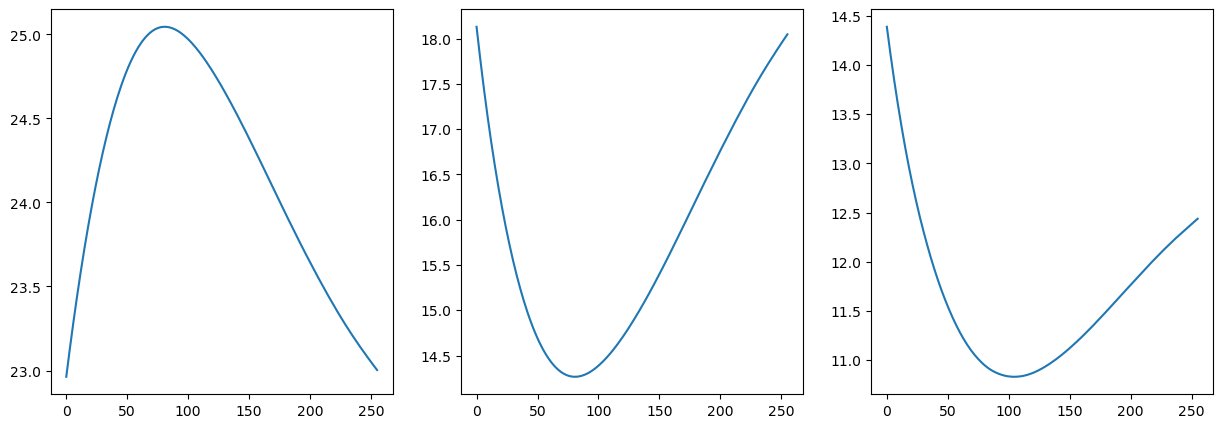

In [25]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(PSNRs_TV_LI)
ax[1].plot(L2s_TV_LI)
ax[2].plot(L1s_TV_LI);

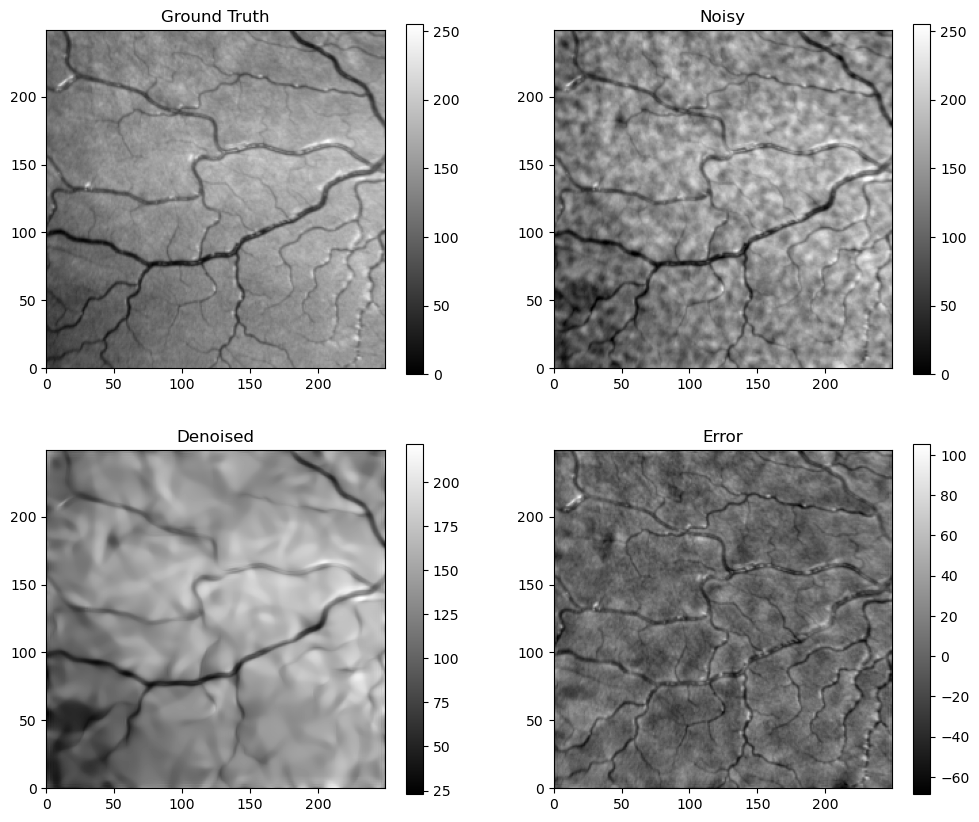

In [26]:
fig, ax = plt.subplots(2, 2, figsize=(2 * im_width, 2 * im_height))
_, _, cbar = plot_image_array(ground_truth, x_min, x_max, y_min, y_max, fig=fig, ax=ax[0, 0])
ax[0, 0].set_title("Ground Truth")
fig.colorbar(cbar, ax=ax[0, 0])
_, _, cbar = plot_image_array(noisy, x_min, x_max, y_min, y_max, fig=fig, ax=ax[0, 1])
ax[0, 1].set_title("Noisy")
fig.colorbar(cbar, ax=ax[0, 1])
_, _, cbar = plot_image_array(U_TV_LI.sum(-1), x_min, x_max, y_min, y_max, clip=clip, fig=fig, ax=ax[1, 0])
ax[1, 0].set_title("Denoised")
fig.colorbar(cbar, ax=ax[1, 0])
_, _, cbar = plot_image_array(ground_truth - np.clip(U_TV_LI.sum(-1), *clip), x_min, x_max, y_min, y_max, fig=fig, ax=ax[1, 1])
fig.colorbar(cbar, ax=ax[1, 1])
ax[1, 1].set_title("Error");

#### Gauge

In [27]:
# First solve for long stopping time to find optimum in terms of PSNR.
_, PSNRs_TV_gauge, L2s_TV_gauge, L1s_TV_gauge = TV_enhancing_gauge(U, ground_truth, np.array((1., ζ**2, 1.)), ξ, dxy, dθ, gauge_frame_static, 1., 0.5, t_TV, λ=λ_TV)
t_opt_TV_gauge = t_TV * max(PSNRs_TV_gauge.argmax(), 1) / PSNRs_TV_gauge.shape[0]
# Result at optimal stopping time.
U_TV_gauge, _, _, _ = TV_enhancing_gauge(U, ground_truth, np.array((1., ζ**-2, 1.)), ξ, dxy, dθ, gauge_frame_static, 1., 0.5, t_opt_TV_gauge, λ=λ_TV)

0.0033128031898852993


100%|██████████| 75/75 [00:03<00:00, 24.60it/s]


0.0033128031898852993


100%|██████████| 23/23 [00:02<00:00,  8.06it/s]


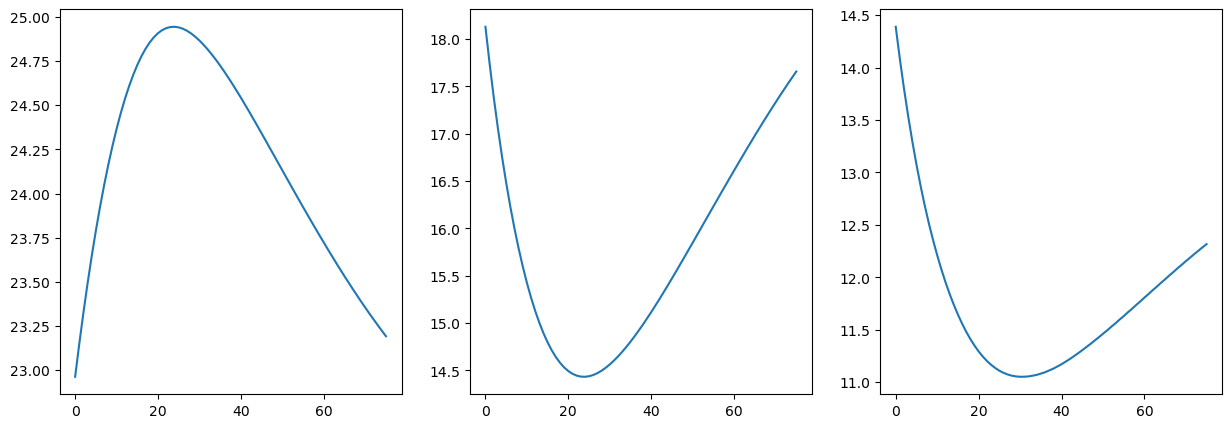

In [28]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(PSNRs_TV_gauge)
ax[1].plot(L2s_TV_gauge)
ax[2].plot(L1s_TV_gauge);

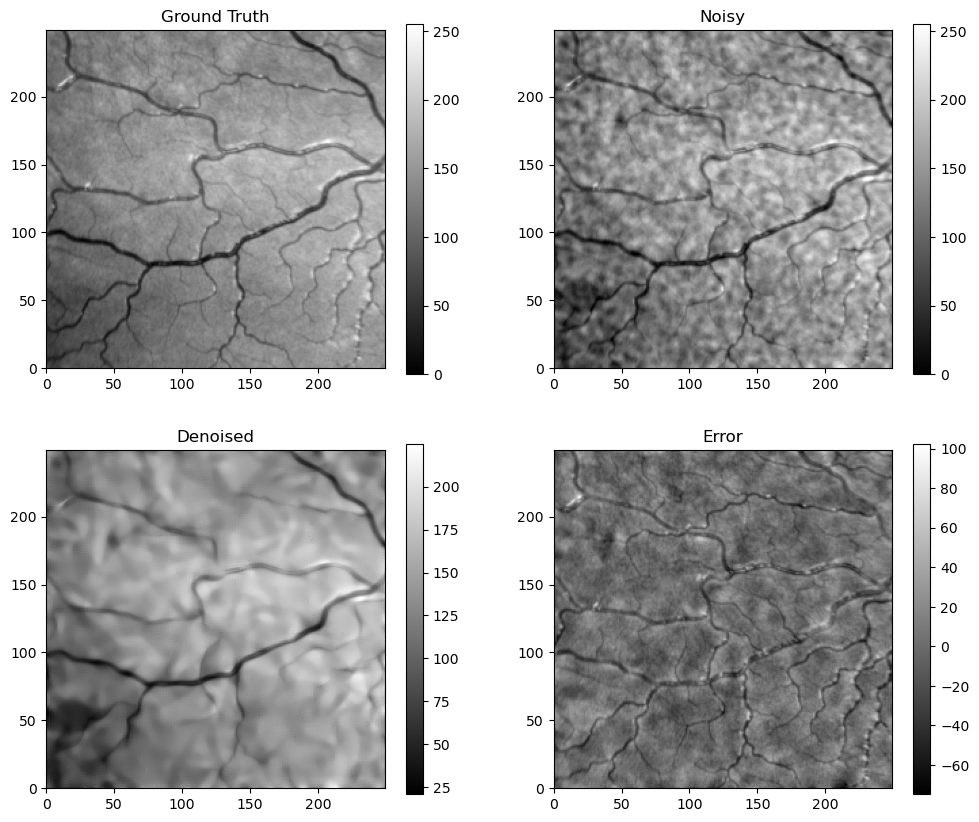

In [29]:
fig, ax = plt.subplots(2, 2, figsize=(2 * im_width, 2 * im_height))
_, _, cbar = plot_image_array(ground_truth, x_min, x_max, y_min, y_max, fig=fig, ax=ax[0, 0])
ax[0, 0].set_title("Ground Truth")
fig.colorbar(cbar, ax=ax[0, 0])
_, _, cbar = plot_image_array(noisy, x_min, x_max, y_min, y_max, fig=fig, ax=ax[0, 1])
ax[0, 1].set_title("Noisy")
fig.colorbar(cbar, ax=ax[0, 1])
_, _, cbar = plot_image_array(U_TV_gauge.sum(-1), x_min, x_max, y_min, y_max, clip=clip, fig=fig, ax=ax[1, 0])
ax[1, 0].set_title("Denoised")
fig.colorbar(cbar, ax=ax[1, 0])
_, _, cbar = plot_image_array(ground_truth - np.clip(U_TV_gauge.sum(-1), *clip), x_min, x_max, y_min, y_max, fig=fig, ax=ax[1, 1])
fig.colorbar(cbar, ax=ax[1, 1])
ax[1, 1].set_title("Error");

### NLM

In [30]:
def nlm_enhancing(noisy, ground_truth, σs, max=clip[1]):
    PSNRs = [PSNR(noisy, ground_truth, max=max)]
    L2s = [L2(noisy, ground_truth)]
    L1s = [L1(noisy, ground_truth)]
    for σ in tqdm(σs[1:]):
        u = denoise_nl_means(noisy, sigma=σ, h=0.6*σ)
        PSNRs.append(PSNR(u, ground_truth, max=max))
        L2s.append(L2(u, ground_truth))
        L1s.append(L1(u, ground_truth))
    return u, np.array(PSNRs), np.array(L2s), np.array(L1s)

In [31]:
# First solve for long stopping time to find optimum in terms of PSNR.
_, PSNRs_nlm, L2s_nlm, L1s_nlm = nlm_enhancing(noisy, ground_truth, σs_nlm)
σ_opt_nlm = σs_nlm[PSNRs_nlm.argmax()]
# Result at optimal stopping time.
u_nlm, _, _, _ = nlm_enhancing(noisy, ground_truth, [0, σ_opt_nlm])

100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


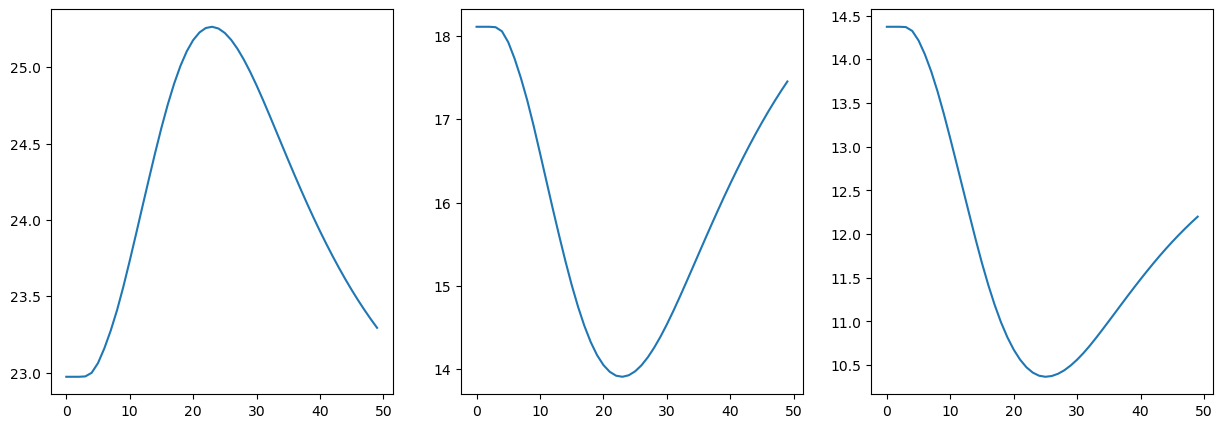

In [32]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(PSNRs_nlm)
ax[1].plot(L2s_nlm)
ax[2].plot(L1s_nlm);

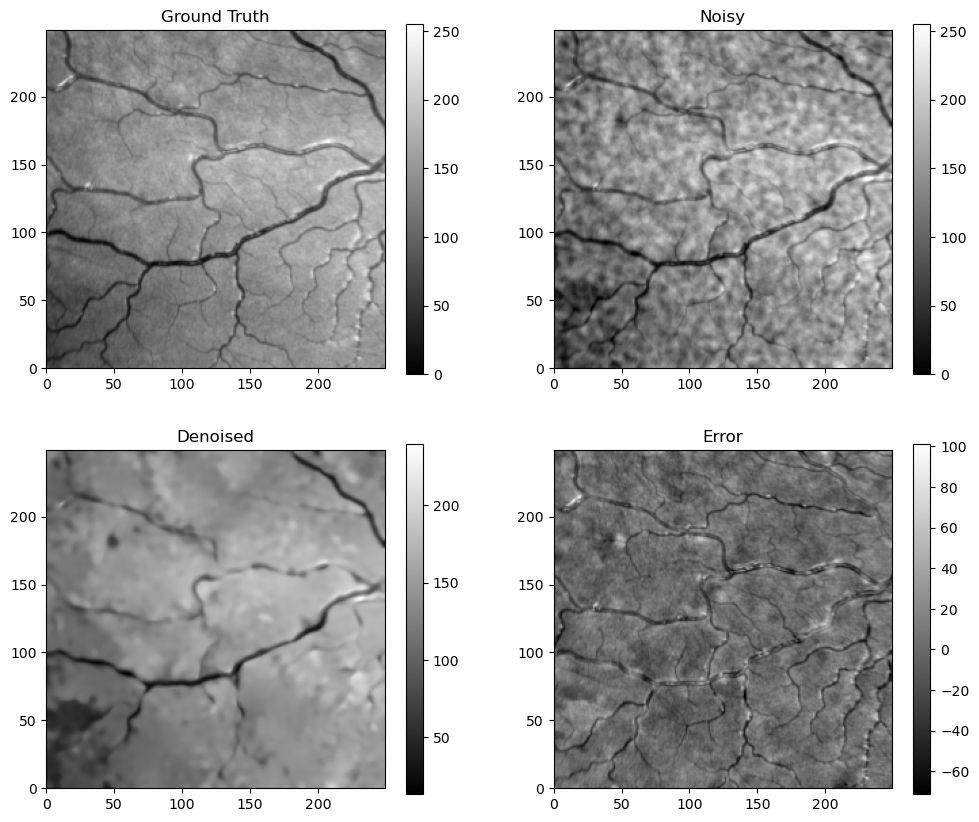

In [33]:
fig, ax = plt.subplots(2, 2, figsize=(2 * im_width, 2 * im_height))
_, _, cbar = plot_image_array(ground_truth, x_min, x_max, y_min, y_max, fig=fig, ax=ax[0, 0])
ax[0, 0].set_title("Ground Truth")
fig.colorbar(cbar, ax=ax[0, 0])
_, _, cbar = plot_image_array(noisy, x_min, x_max, y_min, y_max, fig=fig, ax=ax[0, 1])
ax[0, 1].set_title("Noisy")
fig.colorbar(cbar, ax=ax[0, 1])
_, _, cbar = plot_image_array(u_nlm, x_min, x_max, y_min, y_max, clip=clip, fig=fig, ax=ax[1, 0])
ax[1, 0].set_title("Denoised")
fig.colorbar(cbar, ax=ax[1, 0])
_, _, cbar = plot_image_array(ground_truth - np.clip(u_nlm, *clip), x_min, x_max, y_min, y_max, fig=fig, ax=ax[1, 1])
fig.colorbar(cbar, ax=ax[1, 1])
ax[1, 1].set_title("Error");

### BM3D

In [34]:
def bm3d_enhancing(noisy, ground_truth, σs, max=clip[1]):
    PSNRs = [PSNR(noisy, ground_truth, max=max)]
    L2s = [L2(noisy, ground_truth)]
    L1s = [L1(noisy, ground_truth)]
    for σ in tqdm(σs[1:]):
        u = bm3d(noisy, σ)
        PSNRs.append(PSNR(u, ground_truth, max=max))
        L2s.append(L2(u, ground_truth))
        L1s.append(L1(u, ground_truth))
    return u, np.array(PSNRs), np.array(L2s), np.array(L1s)

In [35]:
# First solve for long stopping time to find optimum in terms of PSNR.
_, PSNRs_bm3d, L2s_bm3d, L1s_bm3d = bm3d_enhancing(noisy, ground_truth, σs_bm3d)
σ_opt_bm3d = σs_bm3d[PSNRs_bm3d.argmax()]
# Result at optimal stopping time.
u_bm3d, _, _, _ = bm3d_enhancing(noisy, ground_truth, [0, σ_opt_nlm])

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


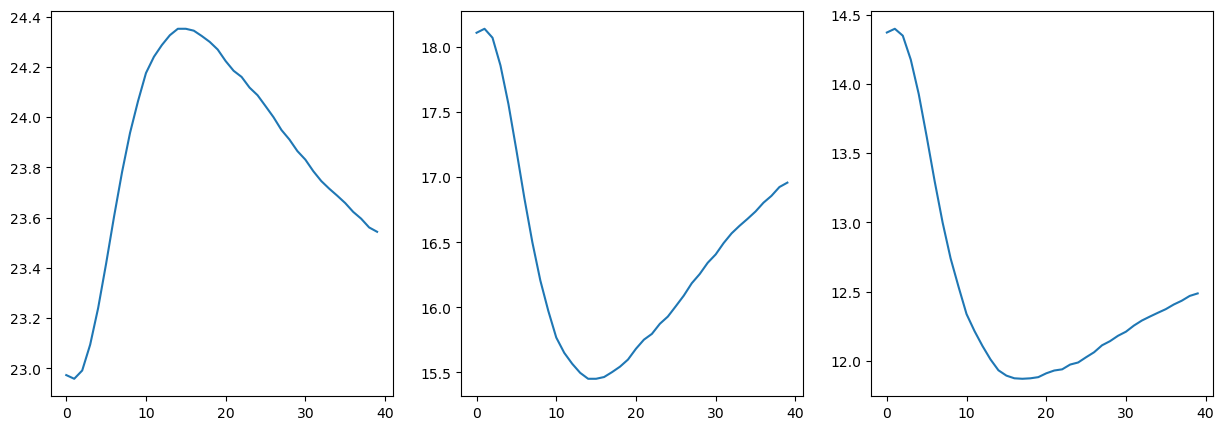

In [36]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(PSNRs_bm3d)
ax[1].plot(L2s_bm3d)
ax[2].plot(L1s_bm3d);

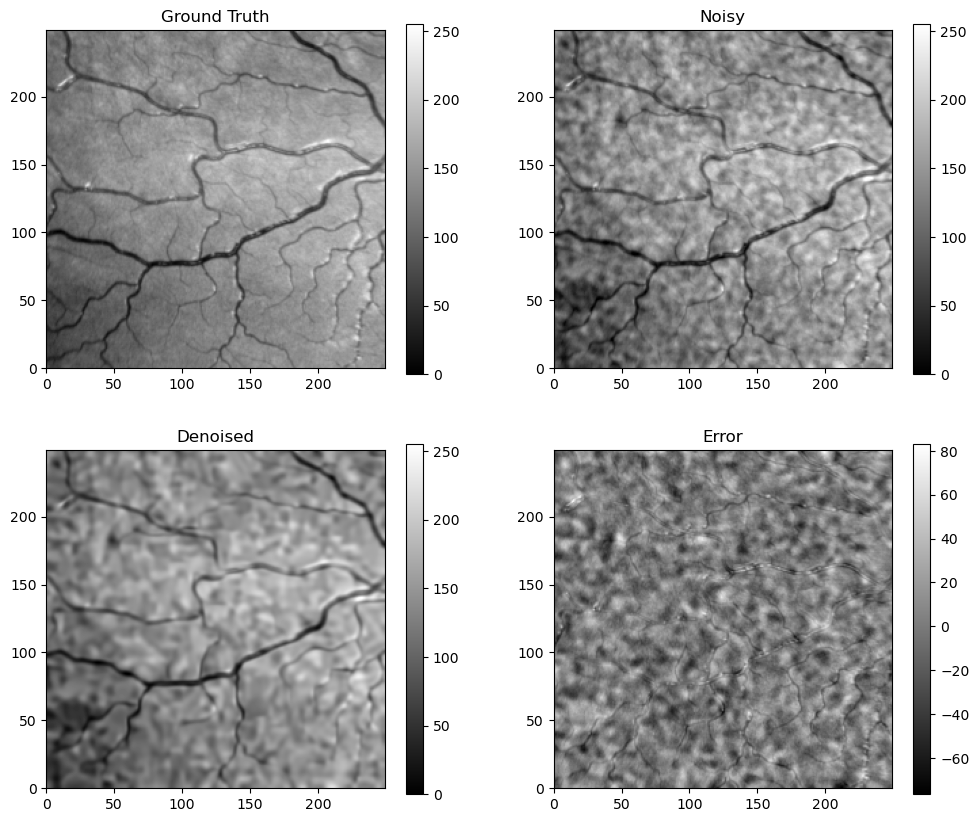

In [37]:
fig, ax = plt.subplots(2, 2, figsize=(2 * im_width, 2 * im_height))
_, _, cbar = plot_image_array(ground_truth, x_min, x_max, y_min, y_max, fig=fig, ax=ax[0, 0])
ax[0, 0].set_title("Ground Truth")
fig.colorbar(cbar, ax=ax[0, 0])
_, _, cbar = plot_image_array(noisy, x_min, x_max, y_min, y_max, fig=fig, ax=ax[0, 1])
ax[0, 1].set_title("Noisy")
fig.colorbar(cbar, ax=ax[0, 1])
_, _, cbar = plot_image_array(u_bm3d, x_min, x_max, y_min, y_max, clip=clip, fig=fig, ax=ax[1, 0])
ax[1, 0].set_title("Denoised")
fig.colorbar(cbar, ax=ax[1, 0])
_, _, cbar = plot_image_array(ground_truth - np.clip(u_bm3d, *clip), x_min, x_max, y_min, y_max, fig=fig, ax=ax[1, 1])
fig.colorbar(cbar, ax=ax[1, 1])
ax[1, 1].set_title("Error");

## Comparison

### Qualitative

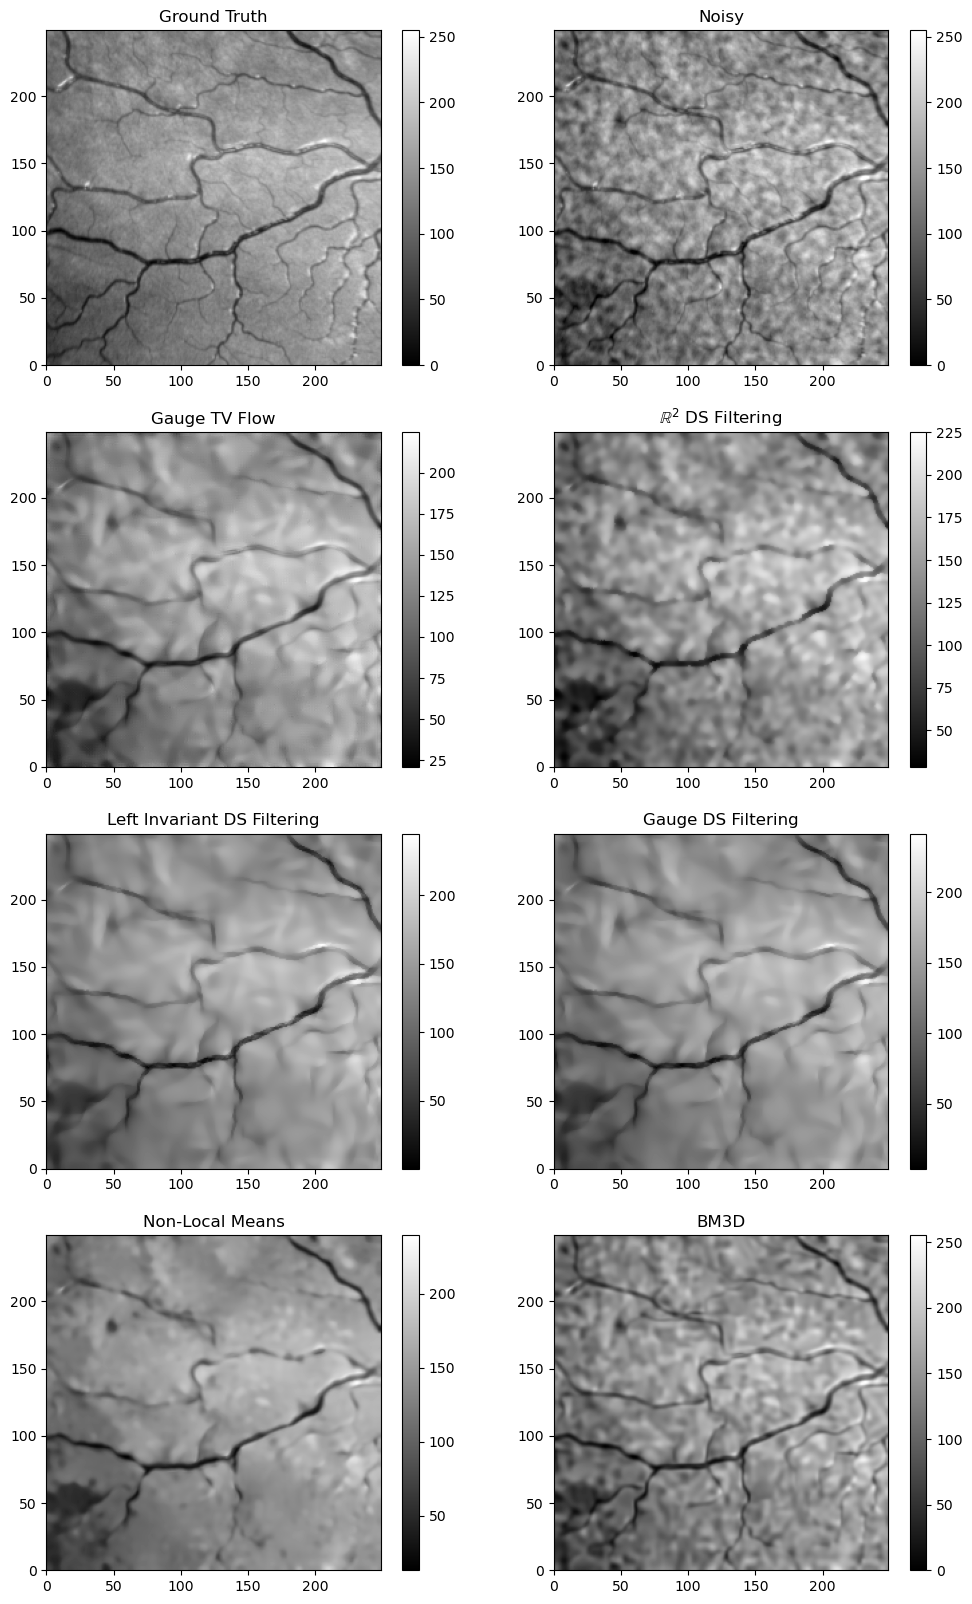

In [38]:
fig, ax = plt.subplots(4, 2, figsize=(2 * im_width, 4 * im_height))
_, _, cbar = plot_image_array(ground_truth, x_min, x_max, y_min, y_max, fig=fig, ax=ax[0, 0])
ax[0, 0].set_title("Ground Truth")
fig.colorbar(cbar, ax=ax[0, 0])
_, _, cbar = plot_image_array(noisy, x_min, x_max, y_min, y_max, fig=fig, ax=ax[0, 1])
ax[0, 1].set_title("Noisy")
fig.colorbar(cbar, ax=ax[0, 1])
_, _, cbar = plot_image_array(U_TV_gauge.sum(-1), x_min, x_max, y_min, y_max, clip=clip, fig=fig, ax=ax[1, 0])
ax[1, 0].set_title("Gauge TV Flow")
fig.colorbar(cbar, ax=ax[1, 0])
_, _, cbar = plot_image_array(u_DS_R2, x_min, x_max, y_min, y_max, clip=clip, fig=fig, ax=ax[1, 1])
fig.colorbar(cbar, ax=ax[1, 1])
ax[1, 1].set_title("$\mathbb{R}^2$ DS Filtering")
_, _, cbar = plot_image_array(U_DS_LI.sum(-1), x_min, x_max, y_min, y_max, clip=clip, fig=fig, ax=ax[2, 0])
fig.colorbar(cbar, ax=ax[2, 0])
ax[2, 0].set_title("Left Invariant DS Filtering")
_, _, cbar = plot_image_array(U_DS_gauge.sum(-1), x_min, x_max, y_min, y_max, clip=clip, fig=fig, ax=ax[2, 1])
fig.colorbar(cbar, ax=ax[2, 1])
ax[2, 1].set_title("Gauge DS Filtering")
_, _, cbar = plot_image_array(u_nlm, x_min, x_max, y_min, y_max, clip=clip, fig=fig, ax=ax[3, 0])
fig.colorbar(cbar, ax=ax[3, 0])
ax[3, 0].set_title("Non-Local Means")
_, _, cbar = plot_image_array(u_bm3d, x_min, x_max, y_min, y_max, clip=clip, fig=fig, ax=ax[3, 1])
fig.colorbar(cbar, ax=ax[3, 1])
ax[3, 1].set_title("BM3D");

### Quantitative

In [39]:
ts_TV_LI = np.linspace(0, t_TV, len(PSNRs_TV_LI)) / t_opt_TV_LI
ts_TV_gauge = np.linspace(0, t_TV, len(PSNRs_TV_gauge)) / t_opt_TV_gauge
ts_DS_LI = np.linspace(0, t_DS_M2, len(PSNRs_DS_LI)) / t_opt_DS_LI
ts_DS_gauge = np.linspace(0, t_DS_M2, len(PSNRs_DS_gauge)) / t_opt_DS_gauge
ts_DS_R2 = np.linspace(0, t_DS_R2, len(PSNRs_DS_R2)) / t_opt_DS_R2
ts_nlm = σs_nlm / max(σ_step_nlm, σ_opt_nlm)
ts_bm3d = σs_bm3d / max(σ_step_bm3d, σ_opt_bm3d)

In [40]:
t_opt_TV_LI, t_opt_TV_gauge, t_opt_DS_LI, t_opt_DS_gauge, t_opt_DS_R2, σ_opt_nlm, σ_opt_bm3d

(np.float64(0.0791015625),
 np.float64(0.07894736842105263),
 np.float64(0.43341404358353514),
 np.float64(0.3280871670702179),
 np.float64(2.8125),
 np.float64(23.0),
 np.float64(70.0))

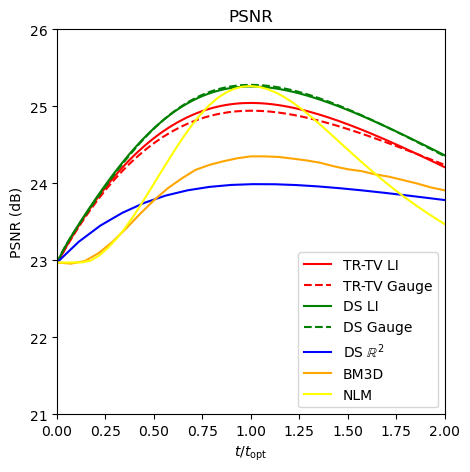

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(ts_TV_LI, PSNRs_TV_LI, label="TR-TV LI", color="red")
ax.plot(ts_TV_gauge, PSNRs_TV_gauge, label="TR-TV Gauge", color="red", linestyle="dashed")
ax.plot(ts_DS_LI, PSNRs_DS_LI, label="DS LI", color="green")
ax.plot(ts_DS_gauge, PSNRs_DS_gauge, label="DS Gauge", color="green", linestyle="dashed")
ax.plot(ts_DS_R2, PSNRs_DS_R2, label="DS $\mathbb{R}^2$", color="blue")
ax.plot(ts_bm3d, PSNRs_bm3d, label="BM3D", color="orange")
ax.plot(ts_nlm, PSNRs_nlm, label="NLM", color="yellow")
ax.set_title("PSNR")
ax.set_xlim(0., 2.)
match test_case:
    case "retina":
        ax.set_ylim(21., 26.)
    case "spiral":
        ax.set_ylim(17.5, 21.5)
ax.set_xlabel("$t / t_{\\mathrm{opt}}$")
ax.set_ylabel("PSNR (dB)")
ax.legend();

### Save Results

In [46]:
PSNRs_nlm.max()

np.float64(25.264511935799554)

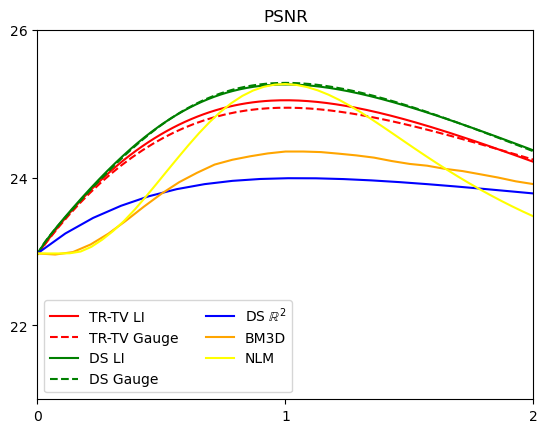

In [42]:
fig, ax = plt.subplots(1, 1)
ax.plot(ts_TV_LI, PSNRs_TV_LI, label="TR-TV LI", color="red")
ax.plot(ts_TV_gauge, PSNRs_TV_gauge, label="TR-TV Gauge", color="red", linestyle="dashed")
ax.plot(ts_DS_LI, PSNRs_DS_LI, label="DS LI", color="green")
ax.plot(ts_DS_gauge, PSNRs_DS_gauge, label="DS Gauge", color="green", linestyle="dashed")
ax.plot(ts_DS_R2, PSNRs_DS_R2, label="DS $\mathbb{R}^2$", color="blue")
ax.plot(ts_bm3d, PSNRs_bm3d, label="BM3D", color="orange")
ax.plot(ts_nlm, PSNRs_nlm, label="NLM", color="yellow")
ax.set_title("PSNR")
ax.set_xlim(0., 2.)
ax.set_xticks([0, 1, 2])
match test_case:
    case "retina":
        ax.set_ylim(21., 26.)
        ax.set_yticks([22, 24, 26])
    case "spiral":
        ax.set_ylim(17.5, 21.5)
        ax.set_yticks([18, 19, 20, 21])
ax.legend(ncol=2)
fig.savefig(f"output\\{test_case}_{storage_name}_PSNRs.png", bbox_inches="tight", dpi=200);

In [43]:
images = []
names = []

images.append(np.clip(U_DS_LI.sum(-1), *clip))
names.append("DS_LI")
images.append(np.clip(U_DS_gauge.sum(-1), *clip))
names.append("DS_gauge")
images.append(np.clip(u_DS_R2, *clip))
names.append("DS_R2")
images.append(np.clip(U_TV_LI.sum(-1), *clip))
names.append("TV_LI")
images.append(np.clip(U_TV_gauge.sum(-1), *clip))
names.append("TV_gauge")
images.append(np.clip(u_nlm, *clip))
names.append("nlm")
images.append(np.clip(u_bm3d, *clip))
names.append("bm3d")

In [44]:
for image, name in zip(images, names):
    Image.fromarray(
        align_to_standard_array_axis_scalar_field(image).astype(np.uint8)
    ).save(f"output\\{test_case}_{storage_name}_{name}.png")